## Dataset Prep

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [3]:
ravdess_list = os.listdir(Ravdess)

files = []
emotions = []

for item in ravdess_list:
    actor = os.listdir(Ravdess + item)
    for file in actor:
        name = file.split('.')[0]
        parts = name.split('-')
        emotions.append(int(parts[2]))
        files.append(Ravdess + item + '/' + file)
        
emotion_data = pd.DataFrame(emotions, columns=['Emotions'])
files_data = pd.DataFrame(files, columns=['Files'])

ravdess_df = pd.concat([emotion_data, files_data], axis=1)

ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

ravdess_df

,Emotions,Files
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
...,...,...
1435,fear,/kaggle/input/ravdess-emotional-speech-audio/a...
1436,angry,/kaggle/input/ravdess-emotional-speech-audio/a...
1437,sad,/kaggle/input/ravdess-emotional-speech-audio/a...
1438,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...


In [4]:
crema = os.listdir(Crema)
emotions = []
files = []

for item in crema:
    files.append(Crema + item)
    
    parts = item.split('_')
    if parts[2] == 'SAD':
        emotions.append('sad')
    elif parts[2] == 'ANG':
        emotions.append('angry')
    elif parts[2] == 'DIS':
        emotions.append('disgust')
    elif parts[2] == 'FEA':
        emotions.append('fear')
    elif parts[2] == 'HAP':
        emotions.append('happy')
    elif parts[2] == 'NEU':
        emotions.append('neutral')
    else :
        emotions.append('unknown')
        
emotions_data = pd.DataFrame(emotions, columns=['Emotions'])
files_data = pd.DataFrame(files, columns=['Files'])

crema_df = pd.concat([emotions_data, files_data], axis=1)

crema_df

,Emotions,Files
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav
...,...,...
7437,angry,/kaggle/input/cremad/AudioWAV/1060_IEO_ANG_MD.wav
7438,angry,/kaggle/input/cremad/AudioWAV/1088_IWL_ANG_XX.wav
7439,angry,/kaggle/input/cremad/AudioWAV/1050_IOM_ANG_XX.wav
7440,sad,/kaggle/input/cremad/AudioWAV/1044_IWL_SAD_XX.wav


In [5]:
tess = os.listdir(Tess)

emotions = []
files = []

for item in tess:
    items = os.listdir(Tess + item)
    for file in items:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            emotions.append('surprise')
        else:
            emotions.append(part)
        files.append(Tess + item + '/' + file)
        
tess_df = pd.concat([pd.DataFrame(emotions, columns=['Emotions']), pd.DataFrame(files, columns=['Files'])], axis=1)

tess_df

,Emotions,Files
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...
...,...,...
2795,surprise,/kaggle/input/toronto-emotional-speech-set-tes...
2796,surprise,/kaggle/input/toronto-emotional-speech-set-tes...
2797,surprise,/kaggle/input/toronto-emotional-speech-set-tes...
2798,surprise,/kaggle/input/toronto-emotional-speech-set-tes...


In [6]:
savee = os.listdir(Savee)

emotions = []
files = []

for item in savee:
    files.append(Savee + item)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele == 'a':
        emotions.append('angry')
    elif ele == 'd':
        emotions.append('disgust')
    elif ele == 'f':
        emotions.append('fear')
    elif ele == 'h':
        emotions.append('happy')
    elif ele == 'n':
        emotions.append('neutral')
    elif ele == 'sa':
        emotions.append('sad')
    else:
        emotions.append('surprise')
        
savee_df = pd.concat([pd.DataFrame(emotions, columns=['Emotions']), pd.DataFrame(files, columns=['Files'])], axis=1)
savee_df

,Emotions,Files
0,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
1,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
2,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
3,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
4,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
...,...,...
475,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
476,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
477,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
478,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...


In [7]:
df = pd.concat([ravdess_df, crema_df, tess_df, savee_df], axis = 0)
df.to_csv("df.csv",index=False)
df

,Emotions,Files
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
...,...,...
475,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
476,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
477,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
478,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...


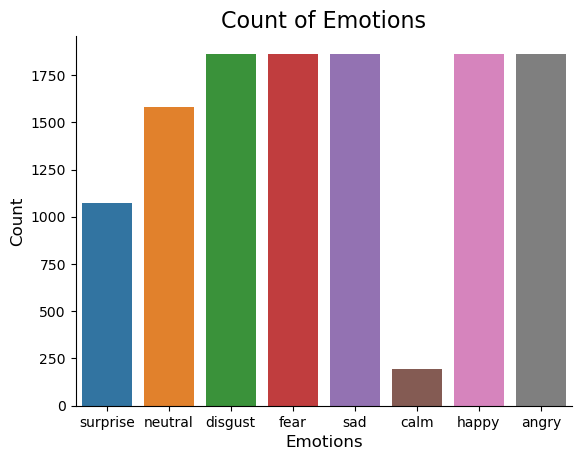

In [8]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=df['Emotions'])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [9]:
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(emotion), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [10]:
def create_spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')  
    plt.colorbar()

In [11]:
def create_wave_spect(emotion):
    path = np.array(df.Files[df.Emotions==emotion])[0]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    return str(path)

## Viewing certain audio spectograms

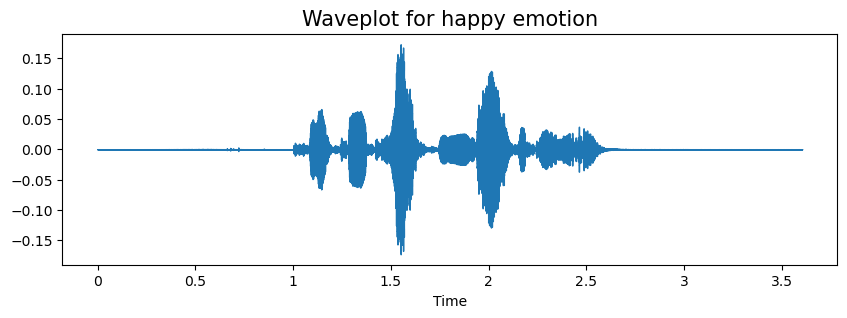

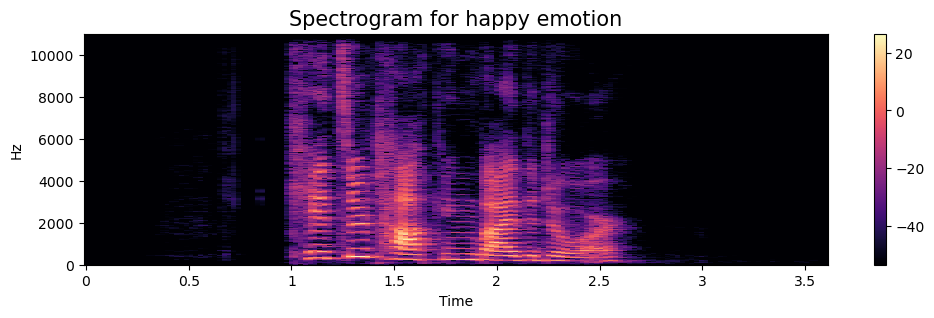

In [12]:
Audio(create_wave_spect('happy'))

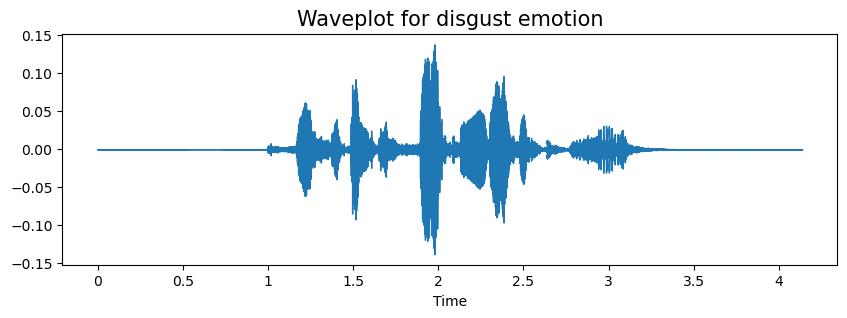

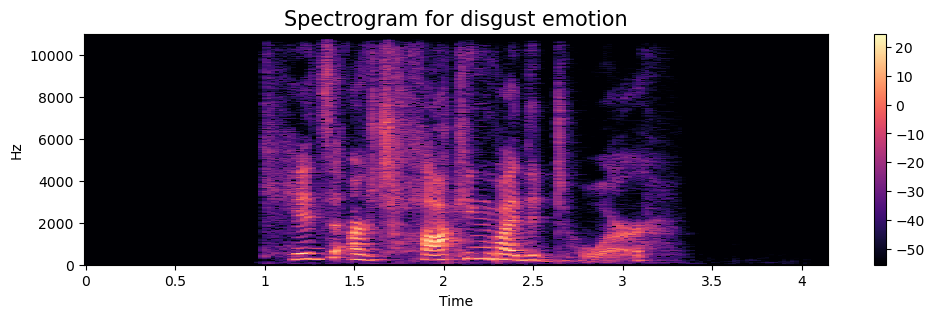

In [13]:
Audio(create_wave_spect('disgust'))

## Data Augmentation

In [14]:
from pydub import AudioSegment
import soundfile as sf


In [15]:
path = np.array(df.Files[df.Emotions=="happy"])[1]
audio, sr = librosa.load(path)
Audio(path)

In [16]:
# Define the desired time stretch factor range
time_stretch_range = (0.9, 1.1)

# Generate a random time stretch factor within the defined range
time_stretch_factor = np.random.uniform(*time_stretch_range)

# Stretch the audio in time
audio_time_stretched = librosa.effects.time_stretch(audio, rate=time_stretch_factor,)

sf.write("time_stretch.wav",audio_time_stretched,sr)
Audio("time_stretch.wav")

In [17]:
# Define the desired noise level range (as a fraction of the audio's peak amplitude)
noise_level_range = (0.001, 0.004)

# Generate a random noise level within the defined range
noise_level = np.random.uniform(*noise_level_range)

# Generate random noise with the same length as the audio
noise = np.random.normal(0, noise_level, len(audio))

# Add the random noise to the audio
audio_with_random_noise = audio + noise

sf.write("noise.wav",audio_with_random_noise,sr)
Audio("noise.wav")

In [18]:
# Define the desired pitch shift range (in semitones)
#pitch_shift_range = 0.5

# Generate a random pitch shift value within the defined range
#pitch_shift_value = np.random.uniform(-pitch_shift_range, pitch_shift_range)

# Shift the pitch of the audio
#audio_pitch_shifted = librosa.effects.pitch_shift(audio,sr=sr, n_steps=pitch_shift_value)

#sf.write('pitch_shifted.wav', audio_pitch_shifted, sr)


In [19]:
#Audio('pitch_shifted.wav')

In [20]:
# countHappy = df["Emotions"].value_counts()["happy"]
# countSurprise = df["Emotions"].value_counts()["surprise"]
# countNeutral = df["Emotions"].value_counts()["neutral"]
# countDisgust = df["Emotions"].value_counts()["disgust"]
# countFear = df["Emotions"].value_counts()["fear"]
# countSad = df["Emotions"].value_counts()["sad"]
# countCalm = df["Emotions"].value_counts()["calm"]
# countAngry=df["Emotions"].value_counts()["angry"]



In [21]:
#countHappy

In [22]:
from tqdm import tqdm

In [23]:
pitch_shift_range = 0.5
pitch_shift_value = np.random.uniform(-pitch_shift_range, pitch_shift_range)

noise_level_range = (0.001, 0.004)
noise_level = np.random.uniform(*noise_level_range)

time_stretch_range = (0.9, 1.1)
time_stretch_factor = np.random.uniform(*time_stretch_range)


emotionsNewNew=[]
filesNewNew=[]

emo=[]
emo={"happy","surprise","neutral","disgust","fear","sad","calm","angry"}

for emotion in emo:
    for i in tqdm(range(df["Emotions"].value_counts()[emotion])):
        path=np.array(df.Files[df.Emotions==emotion])[i]
        audio, sr = librosa.load(path)
        
        audio_pitch_shifted = librosa.effects.pitch_shift(audio,sr=sr, n_steps=pitch_shift_value)
        namePitchShift=emotion+'PitchS'+str(i+1)+'.wav'
        sf.write(namePitchShift, audio_pitch_shifted, sr)
        filesNewNew.append(namePitchShift)
        emotionsNewNew.append(emotion)
        
        noise = np.random.normal(0, noise_level, len(audio))
        audio_with_random_noise = audio + noise
        nameNoise=emotion+"Noise"+str(i+1)+".wav"
        sf.write(nameNoise,audio_with_random_noise,sr)
        filesNewNew.append(nameNoise)
        emotionsNewNew.append(emotion)
        
        audio_time_stretched = librosa.effects.time_stretch(audio, rate=time_stretch_factor,)
        nameTimeStretch=emotion+"TStretch"+str(i+1)+".wav"
        sf.write(nameTimeStretch,audio_time_stretched,sr)
        filesNewNew.append(nameTimeStretch)
        emotionsNewNew.append(emotion)

NewNew_Aug_df = pd.concat([pd.DataFrame(emotionsNewNew, columns=['Emotions']), pd.DataFrame(filesNewNew, columns=['Files'])], axis=1)


NewNew_Aug_df
    

100%|██████████| 1863/1863 [03:30<00:00,  8.84it/s]


,Emotions,Files
0,happy,happyPitchS1.wav
1,happy,happyNoise1.wav
2,happy,happyTStretch1.wav
3,happy,happyPitchS2.wav
4,happy,happyNoise2.wav
...,...,...
36481,disgust,disgustNoise1862.wav
36482,disgust,disgustTStretch1862.wav
36483,disgust,disgustPitchS1863.wav
36484,disgust,disgustNoise1863.wav


## Feature Extraction

In [24]:
#mfcc extraction from augmented data
def extract_mfcc(filename):
    y,sr=librosa.load(filename,duration=3,offset=0.5)
    mfcc=np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)
    return mfcc

In [25]:
X_mfcc=NewNew_Aug_df.iloc[:,1].apply(lambda x:extract_mfcc(x))
X_mfcc

0        [-571.857, 50.72713, -26.299688, 10.27156, -10...
1        [-384.6787, 22.237028, -10.09875, 0.7439168, -...
2        [-577.10596, 50.44056, -25.327715, 9.5287485, ...
3        [-584.68286, 49.734585, -26.076105, 11.933379,...
4        [-384.4848, 23.791159, -8.376986, 2.654865, -4...
                               ...                        
36481    [-337.49442, 56.436157, 0.47666064, 5.281641, ...
36482    [-439.12665, 102.48964, -13.7445135, 19.707483...
36483    [-416.25623, 94.23498, -17.83755, 11.484062, -...
36484    [-327.00137, 58.55455, -3.2401936, 1.5749404, ...
36485    [-419.32776, 101.39823, -16.436977, 11.7894, -...
Name: Files, Length: 36486, dtype: object

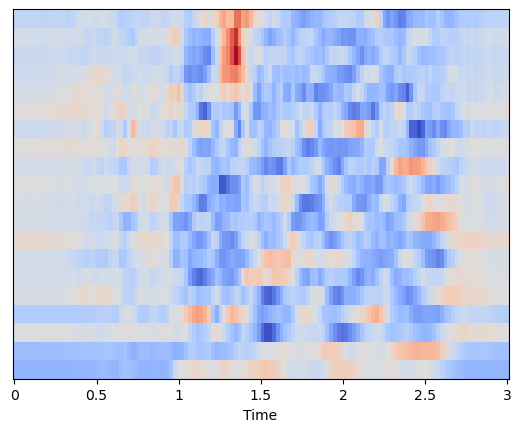

In [27]:
#display of mfcc on sample file after scaling

import sklearn
y,sr=librosa.load(NewNew_Aug_df.iloc[0,1],duration=3)
sample_mfcc=librosa.feature.mfcc(y=y,sr=sr)
sample_mfcc=sklearn.preprocessing.scale(sample_mfcc,axis=1)
sample_mfcc.mean(axis=1)
librosa.display.specshow(sample_mfcc,sr=sr,x_axis='time')

In [28]:
#chroma extraction
def extract_chroma(filename):
    y,sr=librosa.load(filename,duration=3) 
    hop_length=512
    chroma=(librosa.feature.chroma_stft(y=y,sr=sr,hop_length=hop_length))
    return chroma


In [29]:
X_chroma=NewNew_Aug_df.iloc[:,1].apply(lambda x:extract_chroma(x))
X_chroma

0        [[0.64514756, 0.80199623, 1.0, 0.9464695, 0.91...
1        [[0.83676213, 0.7741447, 0.70693505, 0.6106515...
2        [[0.6102343, 0.49271196, 0.6114789, 0.6184579,...
3        [[0.49152258, 0.7404175, 0.9011237, 1.0, 0.995...
4        [[0.93220735, 0.85798025, 0.9099053, 0.7462025...
                               ...                        
36481    [[0.49500412, 0.7787025, 0.6004038, 0.9964453,...
36482    [[0.9350898, 1.0, 0.8678725, 1.0, 0.8726527, 0...
36483    [[1.0, 0.7487924, 0.51276493, 0.24675351, 0.27...
36484    [[0.8489846, 0.8351777, 0.63933855, 0.4931216,...
36485    [[0.75730985, 0.94701797, 0.74547577, 0.564032...
Name: Files, Length: 36486, dtype: object

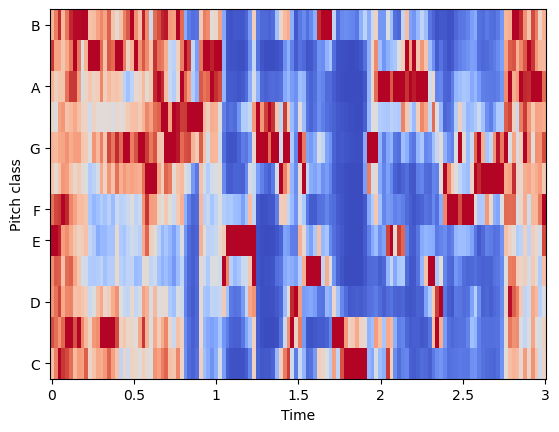

In [30]:
#plotting chromagram for sample sound file
y,sr=librosa.load(NewNew_Aug_df.iloc[0,1],duration=3)
hop_length=512
sample_chroma=librosa.feature.chroma_stft(y=y,sr=sr,hop_length=hop_length)
librosa.display.specshow(sample_chroma,x_axis='time',y_axis='chroma',hop_length=hop_length,cmap='coolwarm')